# Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install pydub
!pip install ffmpeg-python
!pip install tensorflow-addons
!pip install split-folders
!pip install keras_applications
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 20.2 MB/s eta 0:00:00


In [ ]:
import os
import zipfile
import pandas as pd
import pickle
from pydub import AudioSegment
from scipy.io import wavfile as wav
import IPython.display as ipd
from matplotlib import pyplot as plt
import random
import wave
from librosa.feature import mfcc
from sklearn.preprocessing import scale
import numpy as np
import tensorflow as tf
import keras
from scipy.io import wavfile
import scipy.signal as sps
from keras.models import load_model
from ipywidgets import FileUpload
import ipywidgets as widgets
from IPython.display import display, clear_output
from IPython.display import Audio

In [ ]:
from google.colab import files
from matplotlib.figure import Figure
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import io
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

from tensorflow.keras import layers
import splitfolders
from PIL import Image as PILImage
from pathlib import Path

In [ ]:
import shutil
from time import time
from datetime import datetime as dt
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.models import load_model
from keras.preprocessing import image
from keras import backend as K
from keras import Model
from mtcnn.mtcnn import MTCNN
from sklearn.neighbors import KDTree
from sklearn.preprocessing import LabelBinarizer
import joblib
import cv2

In [ ]:
np.random.seed(123)
random.seed(123)
tf.random.set_seed(123)
tf.random.uniform(shape=(1,), seed=123)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.7995876], dtype=float32)>

# Task 1: Image Classification

## Required Functions

In [ ]:
image_data = zipfile.ZipFile('/content/drive/MyDrive/Digital/archive.zip')
image_data.extractall()
image_data.close()

In [ ]:
splitfolders.ratio('blur_dataset_scaled', output="output", seed=1337, ratio=(0.7, 0.2, 0.1))

Copying files: 1050 files [00:09, 111.35 files/s]


In [ ]:
test_path = '/content/output/test/'

test_dir = Path(test_path)

filepaths = list(test_dir.glob(r'**/*.JPG')) + list(test_dir.glob(r'**/*.jpg')) + list(test_dir.glob(r'**/*.png')) + list(test_dir.glob(r'**/*.jpeg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='filepaths', dtype=str)
labels = pd.Series(labels, name='labels', dtype=str)

label_df = pd.concat([filepaths, labels], axis=1)
label_datagen = ImageDataGenerator(preprocessing_function=keras.applications.resnet.preprocess_input)

label_generator = label_datagen.flow_from_dataframe(label_df
                                                  ,x_col='filepaths'
                                                  ,y_col='labels'
                                                  ,target_size = (224, 224)
                                                  ,batch_size = 32
                                                  ,shuffle = False
                                                       )


Found 108 validated image filenames belonging to 3 classes.


In [ ]:
# Function to update the image Dropdown options based on the selected folder
def update_image_options(change):
    selected_folder = change['new']
    image_folder = os.path.join(folder_path, selected_folder)
    # Get the list of all images in the selected folder
    image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
    dropdown_widget.options = image_files

def validate_image(b):
    with output:
        clear_output(wait=True)
        print("Loading selected image...")
        folder = folder_dropdown.value
        image_filename = dropdown_widget.value
        if folder and image_filename:
            # Path of the selected image
            global_image_path_jpg = os.path.join(folder_path, folder, image_filename)
            # Label assigned to the folder
            label = folder

            file_path = '/content/drive/MyDrive/Digital/resnet.h5'
            model_name= 'best model resnet.h5'
            if file_path is not None:
                model = keras.models.load_model(file_path)
                print("Model used for prediction:", model_name)
            else:
                print("File not found")

            try_df = pd.DataFrame({'filepaths': [global_image_path_jpg], 'labels': [label]})
            print(f"Image belonging to {label} category")

            # Using preprocessing
            try_datagen = ImageDataGenerator(preprocessing_function=keras.applications.resnet.preprocess_input)
            try_generator = try_datagen.flow_from_dataframe(try_df,
                                                             x_col='filepaths',
                                                             y_col='labels',
                                                             target_size=(224, 224),
                                                             shuffle=False)

            # use the model to predict the image:
            pred = model.predict(try_generator)
            pred_class = np.argmax(pred, axis=1)
            pred_prob = np.max(pred, axis=1)

            # Map the label
            labels = (label_generator.class_indices)
            labels = dict((v,k) for k,v in labels.items())
            pred_labels = [labels[k] for k in pred_class]

            # retrieve the ground truth species labels
            y_try = list(try_df.labels)

            bimage = plt.imread(global_image_path_jpg)

            if pred_labels == y_try:
                color = 'green'
            else:
                color = 'red'

            # Plot creation
            fig = Figure()
            ax = fig.subplots()
            ax.set_title(f"True: {y_try[0]}\nPredicted: {pred_labels[0]} ({pred_prob[0]*100:.1f}% certain)", color=color)
            ax.axis('off')
            img = PILImage.open(global_image_path_jpg)
            ax.imshow(img)

            # Save the plot in a buffer
            canvas = FigureCanvas(fig)
            buf = io.BytesIO()
            canvas.print_png(buf)
            buf.seek(0)
            with output:
                img = PILImage.open(buf)
                display(img)

            buf.close()
        else:
            print("Folder or image not selected.")

## Demo

In [11]:
# Widget Output to display the image
image_display = widgets.Output()

# Path of the folder containing image folders
folder_path = '/content/drive/MyDrive/Digital/test'

# Get the list of all folders in the directory
sub_folders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]

# Dropdown Widget to select the folder
folder_dropdown = widgets.Dropdown(
    options=sub_folders,
    description='Select Folder:',
    style={'description_width': 'initial', 'font-family': 'cursive', 'font-size': '14px'},
    layout={'width': '50%', 'margin': '10px 0'}
)


# Add the update_image_options function as an observer for the change in the folder Dropdown
folder_dropdown.observe(update_image_options, names='value')

# Dropdown Widget to select the image
dropdown_widget = widgets.Dropdown(
    description='Select Image:',
    style={'description_width': 'initial', 'font-family': 'cursive', 'font-size': '14px'},
    layout={'width': '50%', 'margin': '10px 0'}
)

# Widget Output to display the processing result
output = widgets.Output()

# Button for validating and processing the image
new_validate_button = widgets.Button(description='Validate and Process', layout={'width': '50%', 'margin': '10px 0'})


# Add the on_validate_button_clicked function as a callback on button click
new_validate_button.on_click(validate_image)

# Container to organize the widgets
box = widgets.VBox([folder_dropdown, dropdown_widget, new_validate_button, output],
                         layout=widgets.Layout(
                             display='flex',
                             flex_flow='column',
                             width='100%'
                         ))

display(box)



# Task 2: Image Retrieval

## Required Functions

In [ ]:
image_data = zipfile.ZipFile('/content/drive/MyDrive/Digital/MSRA-CFW/Dataset/thumbnails_features_deduped_publish.zip')
image_data.extractall()
image_data.close()

In [ ]:
def display_img(img_list, nrow = 1, ncol = 0, size = (10,10), text = []):

  if not ncol:
    ncol = len(img_list)

  fig = plt.figure(figsize=(size[0], size[1]))
  k = 0
  for i in range(nrow):
    for j in range(ncol):
      current_plot = fig.add_subplot(nrow, ncol, k+1)
      if k < len(text):
        current_plot.title.set_text(text[k])
      plt.imshow(img_list[k])
      k += 1

In [ ]:
def face_cropper_mtcnn(image, detector):

  # bbox regression con mtcnn


  # predict dei bboxes, l'output e' una lista di dizionari,
  # ogni dizionario ha come chiave 'box' che contiene le coordinate del
  # box (x, y, width, height)
  # oltre ai punti chiave tipo occhi e naso..
  faces = detector.detect_faces(image)

  # itero sui volti identificati
  cropped_list = []
  for face in faces:
    x, y, w, h = face['box']
    cropped_img = image[y:y+h,x:x+w]
    cropped_img = cv2.resize(cropped_img, (160, 160), cv2.INTER_CUBIC)
    cropped_list.append(cropped_img)

  if not np.prod(cropped_list[0].shape):
    cropped_list = [image]
  return cropped_list[0]


def features_cropped_images(images, paths, net = None, prep_fun = None, target_size = (224,224)):

  # estrazione feature su immagini con volto ritagliato
  failed_cropped_path = []
  cropped_path = []
  x = []
  i = 0
  for img in images:
    # print(paths[i])
    # se va in errore il resize (riquadro con alezza nulla) inserisco fra i fail
    try:
      img = cv2.resize(img, target_size, cv2.INTER_CUBIC)
      if prep_fun:
        img = prep_fun(img)
      img = np.expand_dims(img, 0).astype('float16')

      x.append(img)
      cropped_path.append(paths[i])
    except:
      failed_cropped_path.append(paths[i])
    if i%1000 == 0:
      print(i)
    i+=1

  f = np.concatenate(x,0)
  if net:
    f = net.predict(f).astype('float16')

  return f, cropped_path, failed_cropped_path

In [ ]:
def cosine_similarity(vector1, vector2):
    similarities = []
    norm_vector1 = np.linalg.norm(vector1)
    for vec in vector2:
        dot_product = np.dot(vector1, vec)
        norm_vector2 = np.linalg.norm(vec)
        similarity = dot_product / (norm_vector1 * norm_vector2)
        similarities.append(similarity)
    return [float(val) for val in similarities]  # Converti i valori in float e restituisci una lista

In [ ]:
def retrieval_cropping(paths, query_path, tree, net, prep_function, num_image, target_size = (244,244), cropping = False, detector = None):

  # immagine di query
  query_image = cv2.imread(query_path)

  query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)

  # cropping se previsto
  cropped = query_image.copy()
  if cropping:
    cropped = face_cropper_mtcnn(cropped, detector = detector)
  else:
    cropped = cv2.resize(query_image, target_size)

  # estrazione features
  query_features, query_paths, query_fail = features_cropped_images(
      [cropped],
      [query_path],
      net,
      prep_function,
      target_size = target_size
      )

  # best k images
  dist, ind = tree.query(query_features, k = num_image)
  print(ind)
  for i in range(0, num_image):

    print(paths[ind[0][i]])
    print(dist[0][i])
    # immagine corrente
    matching = cv2.imread(paths[ind[0][i]])
    matching = cv2.cvtColor(matching, cv2.COLOR_BGR2RGB)

    display_img([query_image, matching])

  # Utilizzare le features già caricate

  all_features = np.array(features_mobilenet_crop['features_mobilenet'])

  similarity_scores = cosine_similarity(query_features, all_features)

  # Plot delle immagini più simili
  top_indices = np.argsort(similarity_scores)[-num_image:][::-1]
  print(top_indices)
  for i in range(0, num_image):
      print("Similarità del coseno:", similarity_scores[top_indices[i]])  # Stampa la similarità del coseno
      print("Percorso dell'immagine:", paths[top_indices[i]])  # Stampa il percorso dell'immagine
      display_img([kimage.load_img(query_path), kimage.load_img(paths[top_indices[i]])])

In [ ]:
loaded_cropped = np.load('/content/drive/MyDrive/Digital/cropped_images.npz', allow_pickle = True)

In [ ]:
label = []
for path in loaded_cropped['paths']:
    parts = path.split('/')
    if len(parts) >= 6:
        nome = parts[6]
        label.append(nome)

label = list(set(label))

In [ ]:
# Cartella di destinazione
test_folder = 'test'

# Creare la cartella "test" se non esiste
if not os.path.exists(test_folder):
    os.makedirs(test_folder)

# Per ogni nome nella lista label
for nome in label:
    # Percorsi per le cartelle tumb e vip
    tumb_path = os.path.join('thumbnails_features_deduped_publish', nome)
    vip_path = os.path.join('/content/drive/MyDrive/Digital/vip_drive/', nome)
    test_path = os.path.join('test', nome)

    # Creare la sottocartella in "test"
    os.makedirs(test_path, exist_ok=True)

    # Se la sottocartella esiste sia in "tumb" che in "vip"
    if os.path.exists(tumb_path) and os.path.exists(vip_path):
        # Copia le immagini da "tumb" a "test" solo se non sono presenti in "vip"
        for filename in os.listdir(tumb_path):
            if filename not in os.listdir(vip_path):
              shutil.copy(os.path.join(tumb_path, filename), test_path)

In [ ]:
features_mobilenet_crop = np.load('/content/drive/MyDrive/Digital/features_mobilenet_crop.npz', allow_pickle = True)

In [ ]:
test_path = '/content/test/'

test_dir = Path(test_path)

filepaths = list(test_dir.glob(r'**/*.jpg')) + list(test_dir.glob(r'**/*.png')) + list(test_dir.glob(r'**/*.jpeg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='filepaths', dtype=str)
labels = pd.Series(labels, name='labels', dtype=str)

label_df = pd.concat([filepaths, labels], axis=1)

label_datagen = ImageDataGenerator(preprocessing_function=keras.applications.resnet.preprocess_input)

label_generator = label_datagen.flow_from_dataframe(label_df
                                                  ,x_col='filepaths'
                                                  ,y_col='labels'
                                                  ,target_size = (224, 224)
                                                  ,batch_size = 32
                                                  ,shuffle = False
                                                       )

Found 1946 validated image filenames belonging to 30 classes.


In [ ]:
def update_image_options(change):
    selected_folder = change['new']
    image_folder = os.path.join(folder_path, selected_folder)
    # Get the list of all images in the selected folder
    image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f)) and f.lower().endswith('.jpg')]

    dropdown_widget.options = image_files

In [ ]:
def find_similar(b):
      with output:
           global similar_indices
           clear_output(wait=True)
           print("Loading...")
           folder = folder_dropdown.value
           image_filename = dropdown_widget.value
           image_path = os.path.join(folder_path, folder, image_filename)
           if image_path:  # Assicurati che l'immagine sia stata caricata
              print(image_path)
              label = dropdown_widget.value
              mobilenet = mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet',
                                     pooling='max', input_shape=(160, 160, 3))
              tree_mobilenet = KDTree(features_mobilenet_crop['features_mobilenet'])

              detector = MTCNN()
              retrieval_cropping(
                  features_mobilenet_crop['cropped_path_mobilenet'],
                  image_path,
                  tree_mobilenet,
                  mobilenet,
                  prep_function = mobilenet_v2.preprocess_input,
                  num_image = 2,
                  target_size = (160, 160),
                  cropping = face_cropper_mtcnn,
                  detector = detector
                  )

## Demo

In [ ]:
# Widget Output to display the image
image_display = widgets.Output()

# Path of the folder containing image folders
folder_path = '/content/test/'

# Get the list of all folders in the directory
sub_folders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]

# Dropdown Widget to select the folder
folder_dropdown = widgets.Dropdown(
    options=sub_folders,
    description='Select VIP:',
    style={'description_width': 'initial', 'font-family': 'cursive', 'font-size': '14px'},
    layout={'width': '50%', 'margin': '10px 0'}
)


# Add the update_image_options function as an observer for the change in the folder Dropdown
folder_dropdown.observe(update_image_options, names='value')

# Dropdown Widget to select the image
dropdown_widget = widgets.Dropdown(
    description='Select Image:',
    style={'description_width': 'initial', 'font-family': 'cursive', 'font-size': '14px'},
    layout={'width': '50%', 'margin': '10px 0'}
)

# Widget Output to display the processing result
output = widgets.Output()

# Button for validating and processing the image
new_validate_button = widgets.Button(description='Find Similar Images', layout={'width': '50%', 'margin': '10px 0'})


# Add the on_validate_button_clicked function as a callback on button click
new_validate_button.on_click(find_similar)

# Container to organize the widgets
box = widgets.VBox([folder_dropdown, dropdown_widget, new_validate_button, output],
                         layout=widgets.Layout(
                             display='flex',
                             flex_flow='column',
                             width='100%'
                         ))

display(box)



# Task 3: Audio Classification

## Required Functions

In [ ]:
drive_path = "/content/drive/MyDrive/Digital/Audio Classification/"

In [ ]:
sound_rate=44100
loading_output = widgets.Output()
max_length=4000

def resample_audio(input, new_rate=44100):
  sample_rate, clip = wav.read(drive_path + input)
  number_of_samples = round(len(clip) * float(new_rate) / sample_rate)
  clip = sps.resample(clip, number_of_samples)
  return sample_rate, clip

def feats_mfcc_padded(input, rate=sound_rate, tsize=max_length):
    sample_rate, sound_data = wav.read(drive_path + input)
    if sample_rate != sound_rate:
      sample_rate, sound_data = resample_audio(input)

    output = scale(mfcc(y=sound_data*1.0, sr=rate))
    output = output[:,:tsize]

    zeros = np.zeros((output.shape[0], tsize-output.shape[1] ))
    padded = np.concatenate((output, zeros), axis=1)
    return padded

def on_speaker_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
       print("Speaker selected:", change['new'])


def on_upload_change_audio(change):
    if change['new']:
        uploaded_file = list(upload_button.value.values())[-1]
        content = uploaded_file['content']
        original_filepath = drive_path + 'temp_audio_file_original'
        ogg_filepath = drive_path + 'temp_audio_file.wav'

        # Salvare il file originale
        with open(original_filepath, 'wb') as f:
            f.write(content)

        # Determinare il formato del file caricato e convertirlo in .ogg
        format = uploaded_file['metadata']['name'].split('.')[-1]
        if format.lower() == 'mp3':
            audio = AudioSegment.from_mp3(original_filepath)
        elif format.lower() == 'wav':
            audio = AudioSegment.from_wav(original_filepath)
        elif format.lower() == 'flac':
            audio = AudioSegment.from_file(original_filepath, 'flac')
        else:
            # Assumiamo che il formato sia già .ogg
            audio = AudioSegment.from_ogg(original_filepath)

        audio = audio.set_channels(1)

        # Esportare in formato .wav
        audio.export(ogg_filepath, format='wav')

        # Visualizzare l'audio (puoi scegliere di visualizzare l'originale o il .ogg)
        display(Audio(ogg_filepath))

        if not os.path.exists('temp_mfcc'):
            os.makedirs('temp_mfcc')

        # Utilizzare il file .ogg per generare gli spettrogrammi
        #mfcc_paths = feats_mfcc_padded(ogg_filepath)


def classify_mfcc(mfcc_sign, model):
    if not model:
        model = tf.keras.models.load_model(drive_path + 'cnn_model_final')
        last_prediction_label = None

    mfcc_array = mfcc_sign.reshape(1, 20, max_length, 1)
    prediction = model.predict(mfcc_array, verbose=0)[0][0]
    predicted_class_label =  1 if prediction >0.5 else 0
    last_prediction_label = predicted_class_label  # Memorizza l'ultima label predetta
    user_selected_label = speaker_selection.value  # Ottieni la label selezionata dall'utente

    if last_prediction_label is not None:
        stringa = 'NOT' if predicted_class_label==0 else ''
        print("The model predicted that the speaker is " + stringa + " a native English speaker")
        print("The probability of them being a native speaker is {:.2f}%".format(prediction*100))
        print('\n')

def on_classify_button_clicked(b):
    with loading_output:
        clear_output(wait=True)
        print("Loading...")
        print("\n")

    with output_classify:
        clear_output(wait=True)
        mfcc_paths = feats_mfcc_padded('temp_audio_file.wav')
        classify_mfcc(mfcc_paths, None)

def on_classify_button_clicked_recording(recording):
    with loading_output:
        clear_output(wait=True)
        print("Loading...")
        print("\n")

    with output_classify:
        clear_output(wait=True)
        mfcc_paths = feats_mfcc_padded_recording(recording)
        classify_mfcc_recording(mfcc_paths, None)

    with loading_output:
        clear_output(wait=True)

def feats_mfcc_padded_recording(input, rate=sound_rate, tsize=max_length):
    output = scale(mfcc(y=input*1.0, sr=rate))
    output = output[:,:tsize]

    zeros = np.zeros((output.shape[0], tsize-output.shape[1] ))
    padded = np.concatenate((output, zeros), axis=1)
    return padded

def classify_mfcc_recording(mfcc_sign, model):
    if not model:
        model = tf.keras.models.load_model(drive_path + 'cnn_model_final')
        last_prediction_label = None

    mfcc_array = mfcc_sign.reshape(1, 20, max_length, 1)
    prediction = model.predict(mfcc_array, verbose=0)[0][0]
    predicted_class_label =  1 if prediction >0.5 else 0
    last_prediction_label = predicted_class_label  # Memorizza l'ultima label predetta
    user_selected_label = speaker_selection.value  # Ottieni la label selezionata dall'utente

    if last_prediction_label is not None:
        print("The probability of you speaking like a native speaker is {:.2f}%".format(prediction*100))
        if last_prediction_label==1:
          print("You speak just like a native speaker! Congratulations!")
          print('\n')
        else:
          print("You should work on your pronounciation...maybe an English book would help!")
          print('\n')


## DEMO

In [ ]:
import warnings
warnings.filterwarnings("ignore")

style = {'description_width': 'initial'}
layout = {'width': '50%', 'margin': '10px 0'}

loading_output = widgets.Output()


filepath = drive_path + 'labels.pkl'

with open(filepath, 'rb') as f:
    class_labels = pickle.load(f)
class_labels = np.sort(class_labels)



speaker_selection = widgets.Dropdown(
    options=class_labels,
    description='What is the native language of the speaker?',
    disabled=False,
    style=style,
    layout=layout
)

upload_button = widgets.FileUpload(accept='audio/*', multiple=False, style=style, layout=layout)
output = widgets.Output()

upload_button.observe(on_upload_change_audio, names='data')

classify_button = widgets.Button(description="Classify", style=style, layout=layout)
output_classify = widgets.Output()


classify_button.on_click(on_classify_button_clicked)

display(upload_button, speaker_selection, output, classify_button, loading_output, output_classify)
speaker_selection.observe(on_speaker_change)

Output hidden; open in https://colab.research.google.com to view.

### Java code to record audio

In [ ]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

------------------------------------------------------------------

 ### **ARE YOU A NATIVE ENGLISH SPEAKER?**

 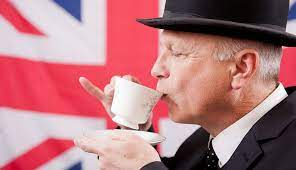

> Check your English skills!

Run the following code snippet and recite the following sentence to find out if you sound like a native English speaker:






"*Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.*"



In [ ]:
audio, sr = get_audio()

In [ ]:
warnings.filterwarnings("ignore")

classify_button = widgets.Button(description="Classify", style=style, layout=layout)
output_classify = widgets.Output()


classify_button.on_click(on_classify_button_clicked_recording(recording = audio))

display(output, classify_button, loading_output, output_classify)
speaker_selection.observe(on_speaker_change)

Output()

Button(description='Classify', layout=Layout(margin='10px 0', width='50%'), style=ButtonStyle())

Output()

Output()